In [1]:
%load_ext autoreload
%autoreload 2
import litebird_sim as lbs
import numpy as np
import healpy as hp
import sbm
import logging
import toml
from pathlib import Path
import matplotlib.pyplot as plt

# from rich import print
logging.basicConfig(level=logging.WARNING)

# Load your Imo in litebird_sim

CONFIG_PATH = Path.home() / ".config" / "litebird_imo"
CONFIG_FILE_PATH = CONFIG_PATH / "imo.toml"
tomlinfo = toml.load(CONFIG_FILE_PATH)
flatfile_location = tomlinfo["repositories"][0]["location"]

imo_version = "v2"
imo = lbs.Imo(flatfile_location=flatfile_location)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
from sbm.scan_fields import extract_location_from_toml
extract_location_from_toml(CONFIG_FILE_PATH)

'/home/serenagiardiello/lbs/litebird_imo/IMO'

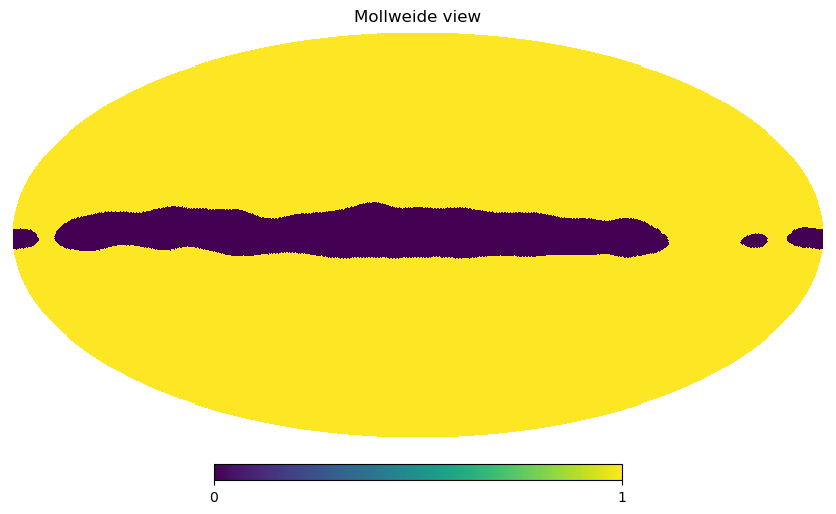

In [3]:
mask = hp.read_map(
    "/home/serenagiardiello/lbs/HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=[5]
    #"/group/cmb/litebird/usr/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=[5]
)
mask = hp.ud_grade(mask, 256)
mask = hp.ud_grade(mask, 128)
hp.mollview(mask)

In [4]:
fg_models = ["pysm_dust_1", "pysm_synch_1", "pysm_co_1"]
sim = lbs.Simulation(random_seed=None)
mdim = 2
cmap = sbm.get_cmap()
# sim_channels = sbm.channel_list[:2] # Only two channels

sim_channels = sbm.channel_list
np.random.seed(123)

gamma_T_list = [1.019031716035418, 1.0426732981603957]
gamma_B_list = [1.0130868422025714, 1.048540936388469]

gamma_T_list = [1.00006, 1.0]
gamma_B_list = [1.0, 1.0]

channel = "M1-140"
detector_name = "001_003_030_00A_" + channel[3:] + "_T"
telescope = channel[0] + "FT"
print(f"Running channel: {channel}")

#sf = sbm.ScanFields.load_det(f"{channel}/{detector_name}",
#           base_path="/home/serenagiardiello/mnt/hawk/scratch/c.spxsg6/lbs/crosslinks_2412_nside_128_3yr_fast_spinrate/")
sf = sbm.ScanFields.load_det(f"{channel}/{detector_name}",
                            base_path="/home/serenagiardiello/mnt/hawk/scratch/c.spxsg6/lbs/crosslinks_2412_nside_128_3yr_fast_spinrate/")

Mbsparams = lbs.MbsParameters(
    make_cmb=False,
    cmb_r=0.0,
    make_fg=True,
    seed_cmb=1234,
    fg_models=fg_models,
    gaussian_smooth=False,
    bandpass_int=False,
    nside=sf.nside,
    units="uK_CMB",
    maps_in_ecliptic=False,
)
ch_info = lbs.FreqChannelInfo.from_imo(
    url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
    imo=imo,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info,
)
map_info = mbs.run_all()[0]
fgs = mbs.generate_fg()[0]

component_tmaps = [fgs[fg_models[0]][0,0], fgs[fg_models[1]][0,0]]
temp = map_info[channel][0]
pol = map_info[channel][1] + 1j * map_info[channel][2]

signal_field = sbm.SignalFields.bandpass_mismatch_field(
    sf,
    mdim,
    pol,
    gamma_T_list,
    gamma_B_list,
    component_tmaps,
)
output_map = sf.map_make(signal_field, show_eq=False)
residual = output_map - map_info[channel]

Running channel: M1-140


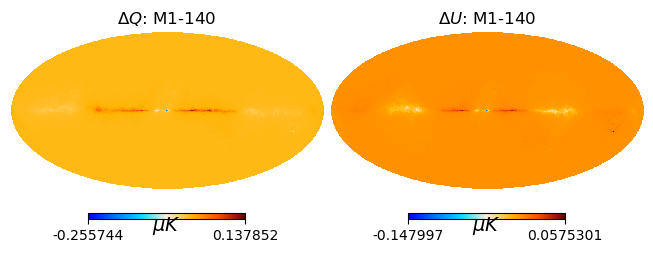

In [6]:
val = 0.05
hp.mollview(
    residual[1],
    title=f"$\Delta Q$: {channel}",
    cmap=cmap,
    sub=(1, 2, 1),
    unit="$\mu K$",
    #min=-val, max=val,
)
hp.mollview(
    residual[2],
    title=f"$\Delta U$: {channel}",
    cmap=cmap,
    sub=(1, 2, 2),
    unit="$\mu K$",
    #min=-val, max=val,
)

In [7]:
def apply_mask(maps, mask):
    m = maps * mask
    m[m == 0.0] = hp.UNSEEN
    return m

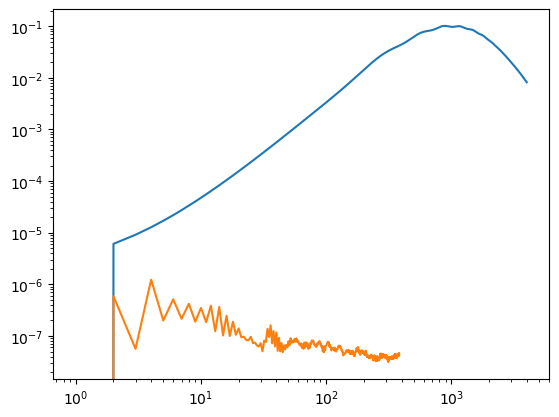

In [8]:
cl = sbm.load_fiducial_cl(r=0)

cl_140_bore = hp.anafast(apply_mask(residual, mask))
plt.loglog(sbm.c2d(cl[2]))
plt.loglog(sbm.c2d(cl_140_bore[2]))

In [9]:
#function to select two (closest to) boresight couple of detectors
def detector_list(instrument, channel):
    if (
        instrument == "MFT"
        and not channel[3:] == "119"
        and not channel[3:] == "166"
    ):
        detlist = [
            "001_003_030_00A_" + channel[3:] + "_T",
            "001_003_030_00A_" + channel[3:] + "_B",
        ]
    elif (
        instrument == "MFT"
        and channel[3:] == "119"
        or channel[3:] == "166"
    ):
        detlist = [
            "001_001_026_15A_" + channel[3:] + "_T",
            "001_001_026_15A_" + channel[3:] + "_B",
        ]
    elif (
        instrument == "LFT"
        and channel[3:] == "040"
        or channel[3:] == "060"
        or channel == "L1-078"
    ):
        detlist = [
            "000_000_008_UA_" + channel[3:] + "_T",
            "000_000_008_UA_" + channel[3:] + "_B",
        ]
    elif (
        instrument == "LFT"
        and channel[3:] == "050"
        or channel == "L2-068"
        or channel == "L2-089"
    ):
        detlist = [
            "000_000_002_UA_" + channel[3:] + "_T",
            "000_000_002_UA_" + channel[3:] + "_B",
        ]
    elif (
        instrument == "LFT"
        and channel == "L3-068"
        or channel == "L3-089"
        or channel[3:] == "119"
    ):
        detlist = [
            "000_001_035_UB_" + channel[3:] + "_T",
            "000_001_035_UB_" + channel[3:] + "_B",
        ]
    elif (
        instrument == "LFT"
        and channel == "L4-078"
        or channel[3:] == "100"
        or channel[3:] == "140"
    ):
        detlist = [
            "000_001_017_QB_" + channel[3:] + "_T",
            "000_001_017_QB_" + channel[3:] + "_B",
        ]
    elif (
        instrument == "HFT"
        and channel[3:] == "235"
        or channel[3:] == "337"
    ):
        detlist = [
            "002_001_069_Q_" + channel[3:] + "_T",
            "002_001_069_Q_" + channel[3:] + "_B",
        ]
    elif (
        instrument == "HFT"
        and channel[3:] == "195"
        or channel[3:] == "280"
    ):
        detlist = [
            "002_000_120_Q_" + channel[3:] + "_T",
            "002_000_120_Q_" + channel[3:] + "_B",
        ]
    elif instrument == "HFT" and channel[3:] == "402":
        detlist = [
            "002_002_000_Q_" + channel[3:] + "_T",
            "002_002_000_Q_" + channel[3:] + "_B",
        ]

    else:
        raise RuntimeError("No list of detector provided!")
    return detlist

In [11]:
syst = sbm.Systematics()
freq_maps = []
freq_maps_input = []
freq_maps_res = []
#fg_models = ["pysm_dust_1", "pysm_synch_1", "pysm_freefree_1", "pysm_ame_1", "pysm_co_1"]
fg_models = ["pysm_dust_0", "pysm_synch_0"]
#fg_models = ["pysm_dust_1", "pysm_synch_1", "pysm_co_1"]

#adding gaussian noise on the bandpasses
sigma_band = 0.05

Mbsparams = lbs.MbsParameters(
    make_cmb=False,
    cmb_r=0.0,
    make_fg=True,
    seed_cmb=1234,
    fg_models=fg_models,
    gaussian_smooth=False,
    bandpass_int=False,
    nside=128,
    units="uK_CMB",
    maps_in_ecliptic=False,
)

np.random.seed(0)
for channel in sbm.channel_list:
    config = sbm.Configlation(imo, channel)
    config.mdim = 2 #2
    config.parallel = True
    config.nside = 128
    config.xlink_threshold = 0.7  # avoid mapmake in singular pixels
    config.use_hwp = False

    # Define the telescope
    telescope = channel[0] + "FT"


    # Load the channel info
    ch_info = lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )


    #detectors = ch_info.detector_names[:6]

    detectors = detector_list(telescope, channel)

    dets = []
    for n_det in detectors:
        det = lbs.DetectorInfo.from_imo(
            url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
            imo=imo,
        )
        dets.append(det)

    print(len(dets))

    bandcenter_ghz = dets[0].bandcenter_ghz
    bandwidth_ghz = dets[0].bandwidth_ghz

    band_low_edge = bandcenter_ghz - bandwidth_ghz / 2.0
    band_high_edge = bandcenter_ghz + bandwidth_ghz / 2.0

    # generating different bandpasses for each detector
    for di, det in enumerate(detectors):
        #sf = sbm.ScanFields.load_det(f"{channel}/{det}",
     #base_path="/home/serenagiardiello/mnt/hawk/scratch/c.spxsg6/lbs/crosslinks_2412_nside_128_3yr_fast_spinrate/")

        #sh = np.random.uniform(-0.005, 0.005, 1)  # uniform distribution with 0.01 width
        Band = lbs.BandPassInfo(
            bandcenter_ghz=bandcenter_ghz, #* (1 + sh),
            bandwidth_ghz=0.8
            * bandwidth_ghz,  # to have the wings cross the band extremes at ~0.5
            bandlow_ghz=max(0, band_low_edge - 50),
            bandhigh_ghz=band_high_edge + 50,
            bandtype="cheby",
            normalize=False,
            nsamples_inband=len(
                np.arange(max(0, band_low_edge - 50), band_high_edge + 50, 1)
            ),  # bandpass sampled from center +- 2width,
            # to have a 0.5 GHz resol. we should ask from 4*width points
            cheby_ripple_dB=0.2,
            cheby_poly_order=3,
        )


        err_inband = sigma_band*np.random.normal(0.0, 1.0, Band.weights.size)
        Band.weights += err_inband

        Band.freqs_ghz = Band.freqs_ghz[Band.weights**2 >= 0.01]
        Band.weights = (
            (Band.weights[Band.weights**2 >= 0.01]) ** 2
            / Band.freqs_ghz
            / Band.freqs_ghz
            / 1e18
        )

        dets[di].band_freqs_ghz = Band.freqs_ghz
        dets[di].band_weights = Band.weights

    syst.set_bandpass_mismatch(detectors)

    output, input_map = sbm.sim_bandpass_mismatch(
        config,
        syst,
        Mbsparams,
        dets,
       base_path="/home/serenagiardiello/mnt/hawk/scratch/c.spxsg6/lbs/crosslinks_2412_nside_128_3yr_fast_spinrate/"
        #base_path="/home/cmb/yusuket/gp/KDP/sbm_outputs/BPM/test01/",
    )
    freq_maps.append(output)
    freq_maps_input.append(input_map)
    freq_maps_res.append(output - input_map)

freq_maps = np.array(freq_maps)
freq_maps_input = np.array(freq_maps_input)
freq_maps_res = np.array(freq_maps_res)

2


Processing L1-040: 100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


2


Processing L2-050: 100%|██████████| 1/1 [00:05<00:00,  5.09s/it]


2


Processing L1-060: 100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


2


Processing L3-068: 100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


2


Processing L2-068: 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]


2


Processing L4-078: 100%|██████████| 1/1 [00:09<00:00,  9.48s/it]


2


Processing L1-078: 100%|██████████| 1/1 [00:08<00:00,  8.58s/it]


2


Processing L3-089: 100%|██████████| 1/1 [00:08<00:00,  8.96s/it]


2


Processing L2-089: 100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


2


Processing L4-100: 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


2


Processing L3-119: 100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


2


Processing L4-140: 100%|██████████| 1/1 [00:08<00:00,  8.23s/it]


2


Processing M1-100: 100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


2


Processing M2-119: 100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


2


Processing M1-140: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


2


Processing M2-166: 100%|██████████| 1/1 [00:09<00:00,  9.38s/it]


2


Processing M1-195: 100%|██████████| 1/1 [00:08<00:00,  8.62s/it]


2


Processing H1-195: 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]


2


Processing H2-235: 100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


2


Processing H1-280: 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]


2


Processing H2-337: 100%|██████████| 1/1 [00:08<00:00,  8.83s/it]


2


Processing H3-402: 100%|██████████| 1/1 [00:09<00:00,  9.46s/it]


/tmp/ipykernel_24966/2441941634.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


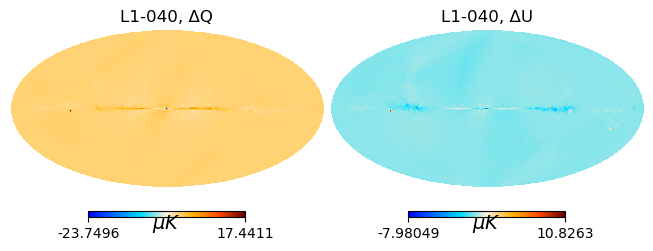

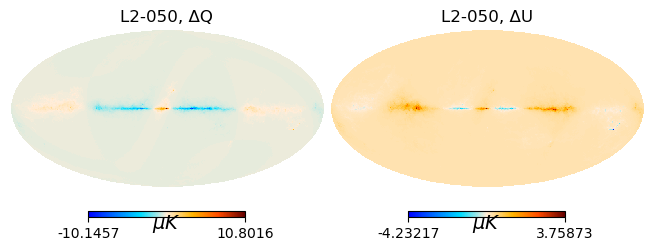

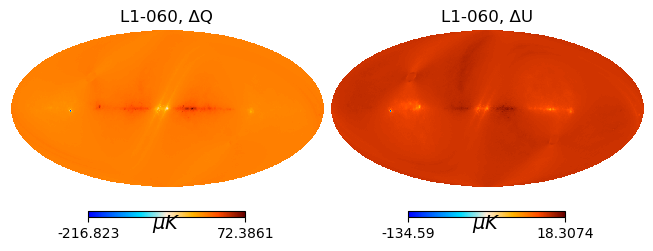

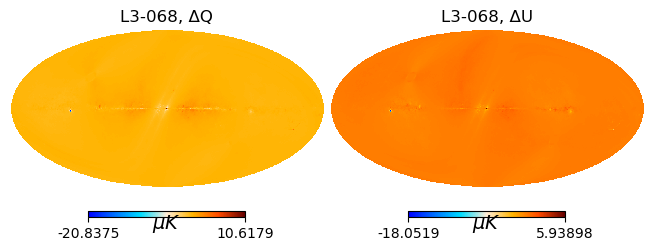

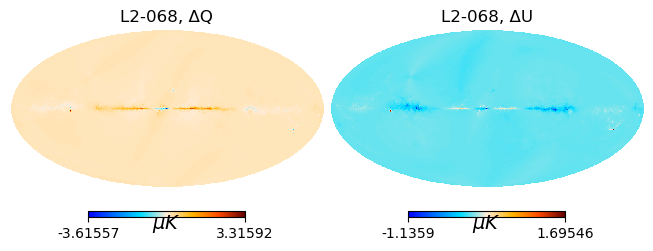

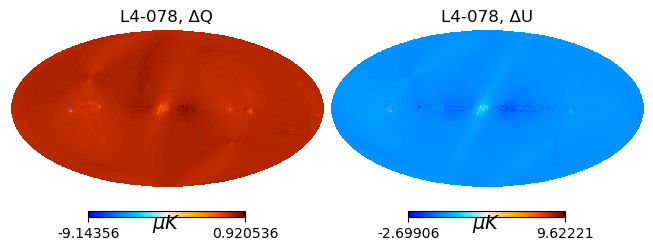

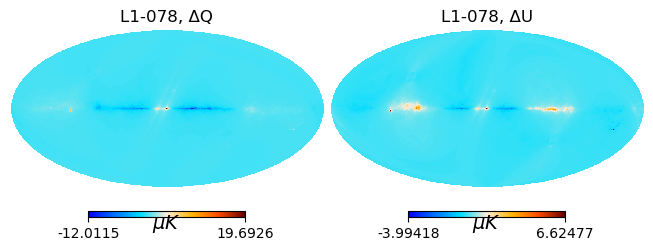

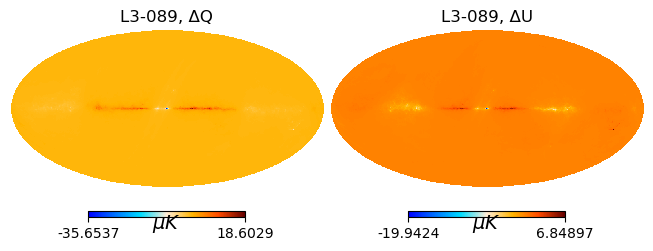

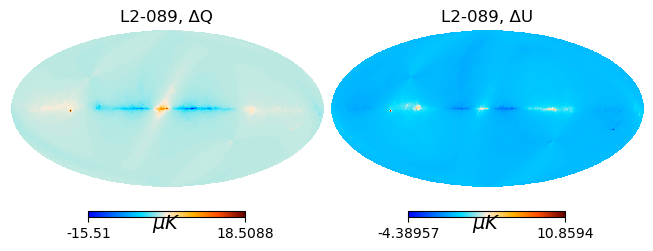

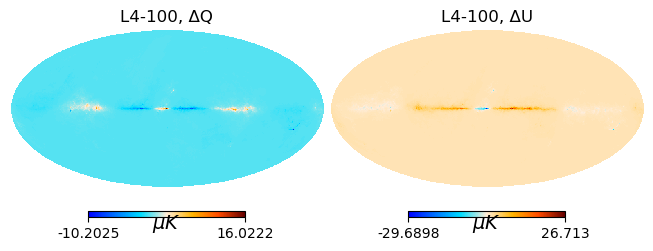

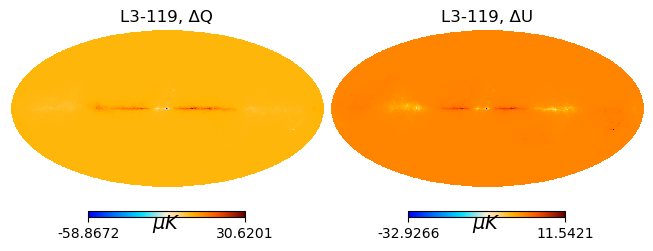

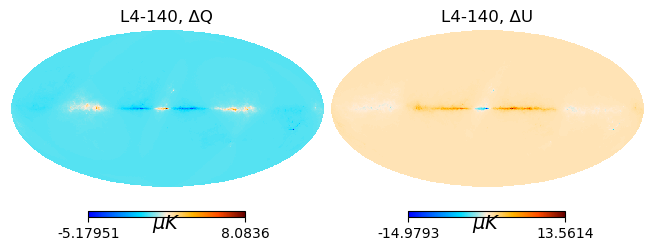

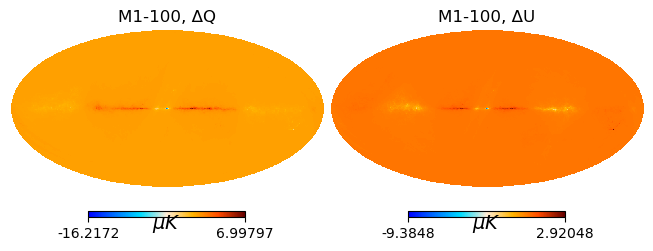

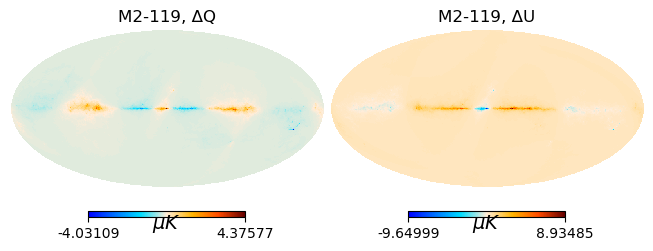

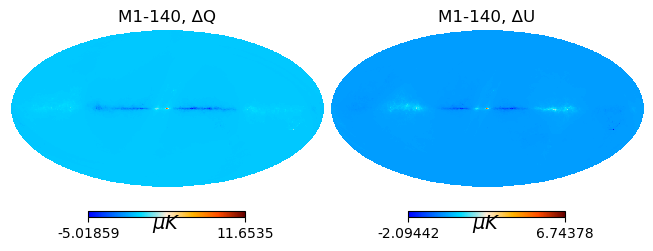

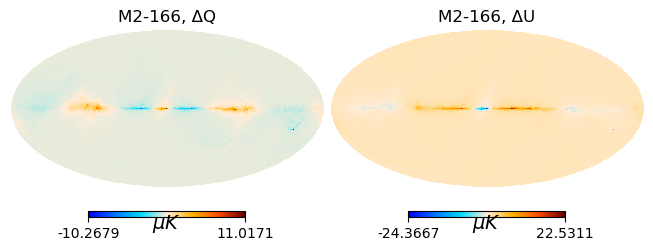

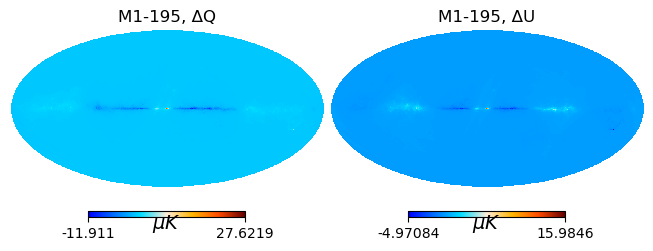

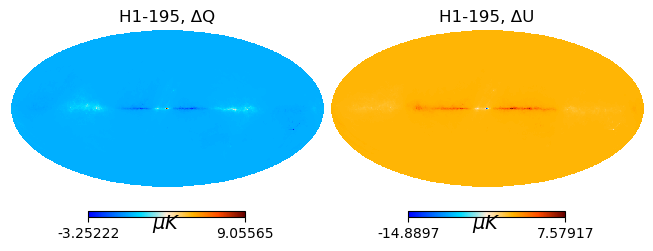

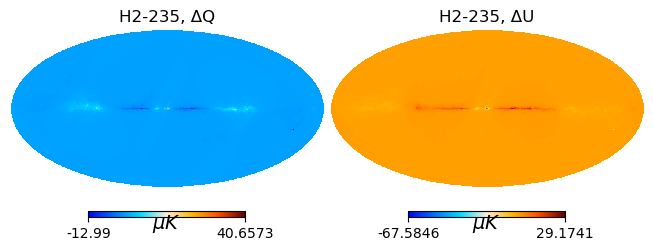

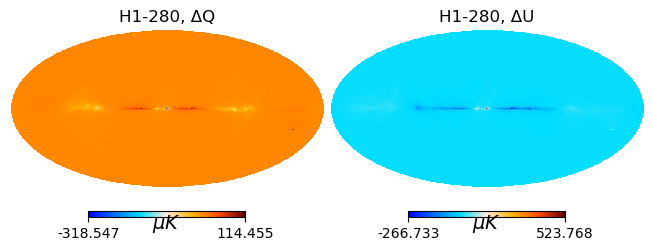

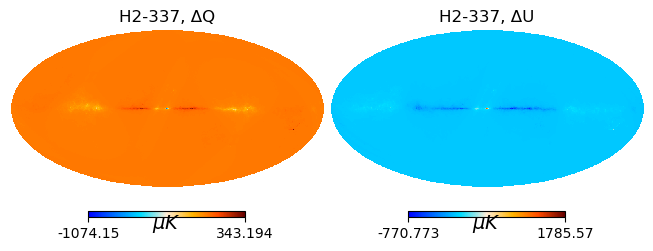

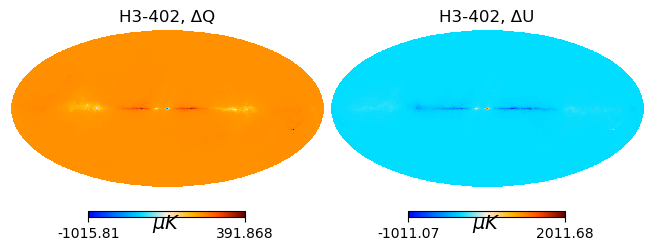

In [12]:
# run with with config.mdim = 2
val = 5
cmap = sbm.get_cmap()

for i,ch in enumerate(sbm.channel_list):
    plt.figure()
    hp.mollview(freq_maps_res[i][1], cmap=cmap, sub=(1,2,1),title=f"{ch}, ΔQ", unit="$\mu K$") # min=-val, max=val,
    hp.mollview(freq_maps_res[i][2], cmap=cmap, sub=(1,2,2), title=f"{ch}, ΔU",unit="$\mu K$") #min=-val, max=val,

/tmp/ipykernel_10910/2603557122.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


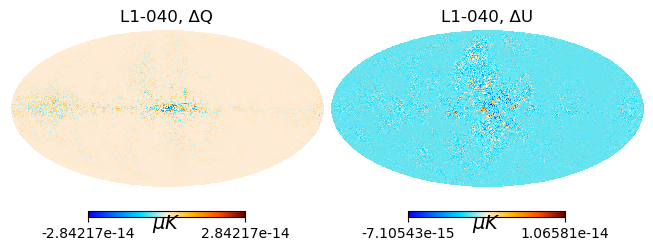

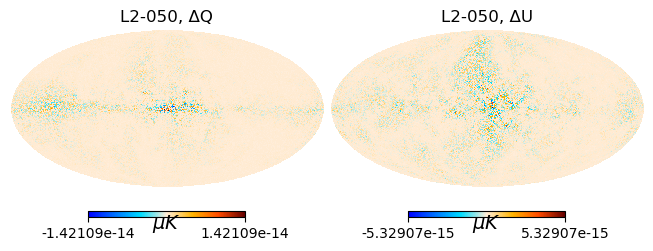

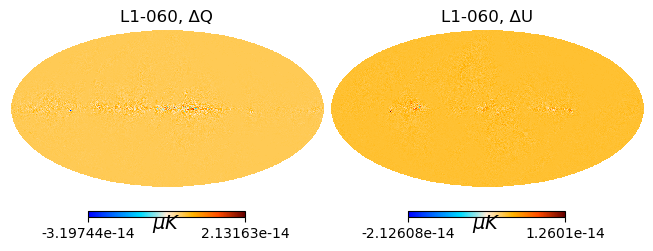

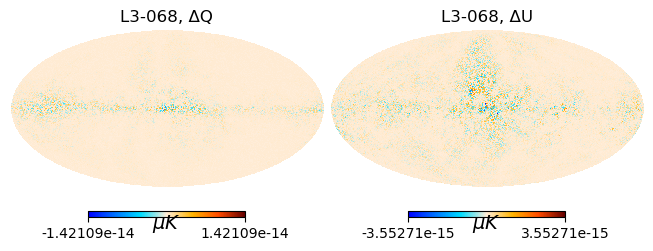

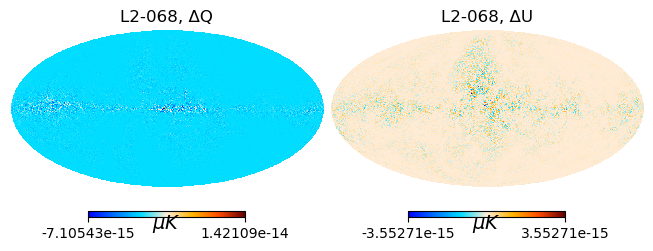

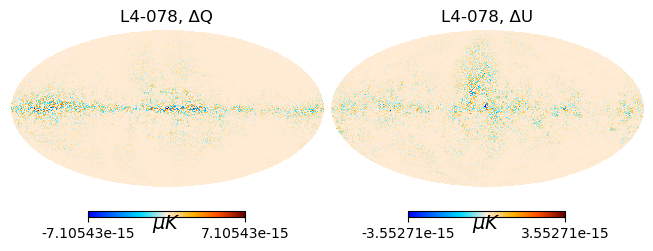

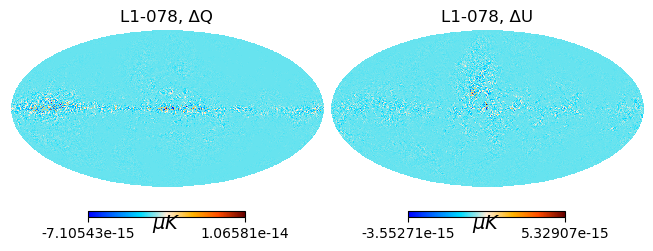

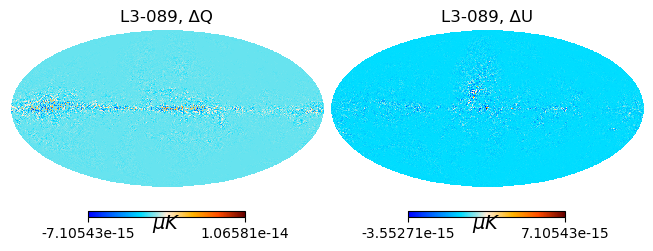

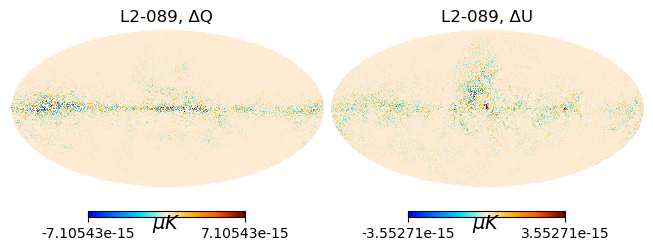

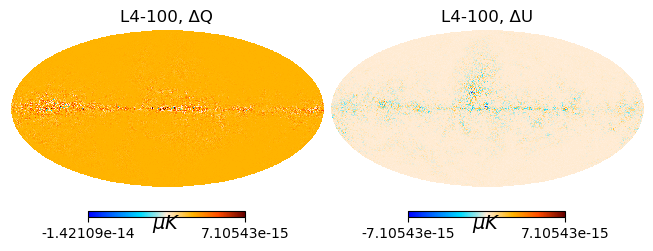

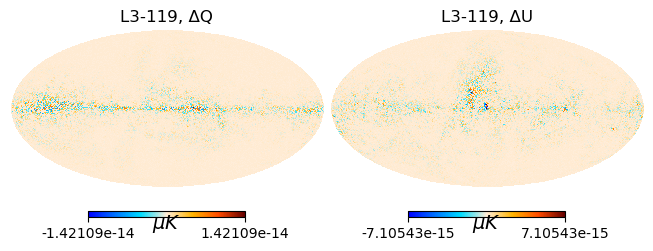

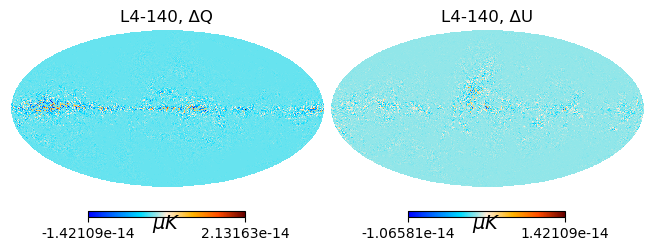

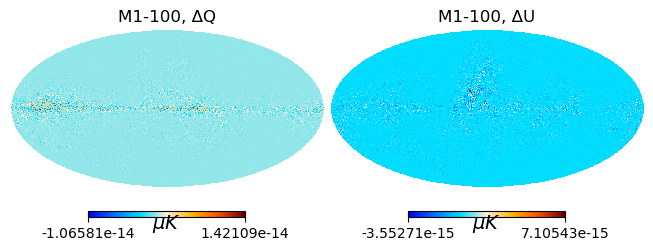

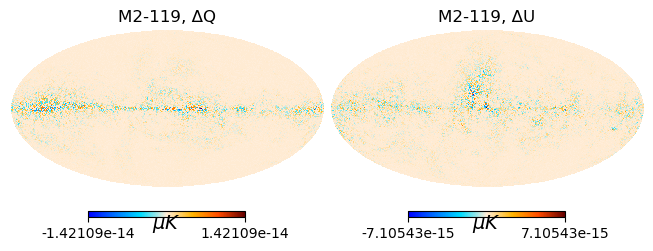

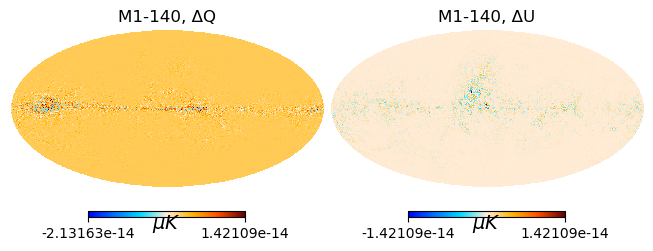

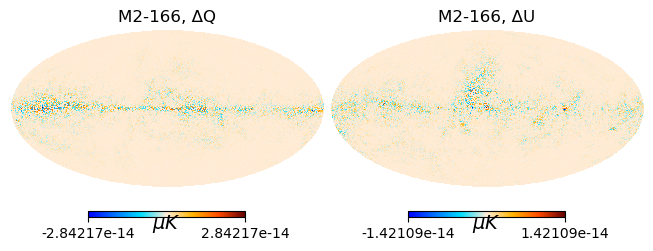

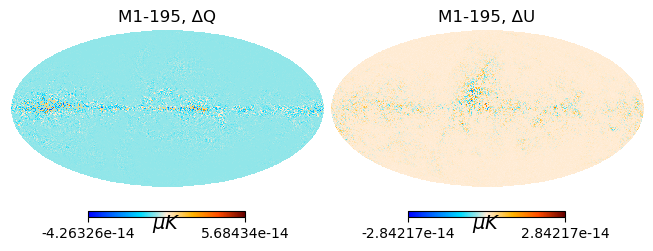

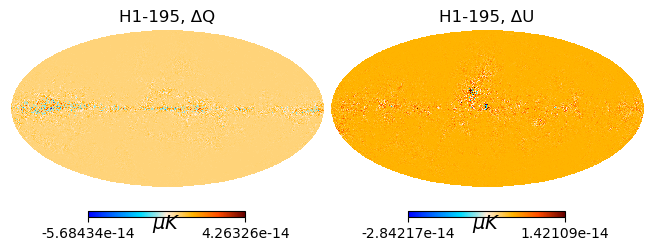

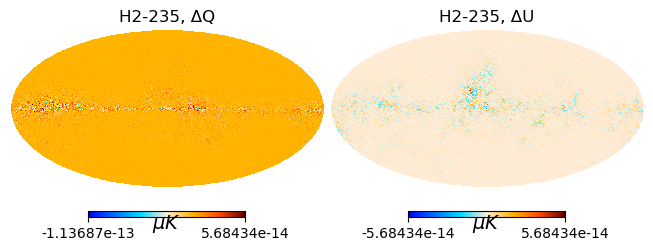

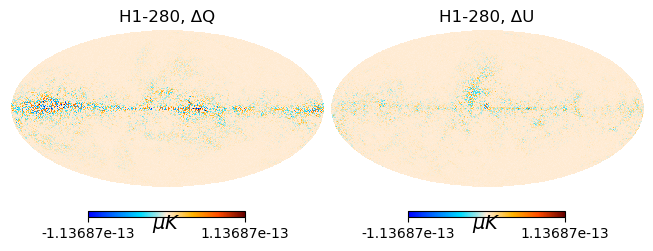

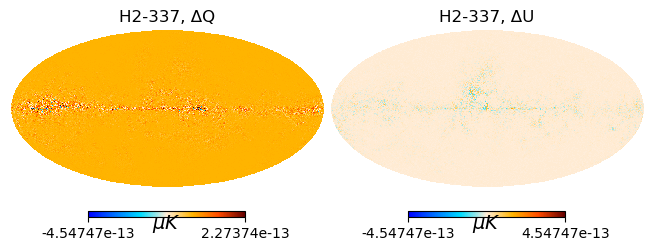

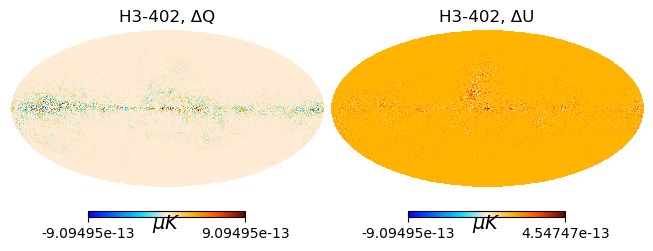

In [ ]:
# run with with config.mdim = 3
val = 5

for i,ch in enumerate(sbm.channel_list):
    plt.figure()
    hp.mollview(freq_maps_res[i][1], cmap=cmap, sub=(1,2,1),title=f"{ch}, ΔQ", unit="$\mu K$") # min=-val, max=val,
    hp.mollview(freq_maps_res[i][2], cmap=cmap, sub=(1,2,2), title=f"{ch}, ΔU", unit="$\mu K$") #min=-val, max=val,

Text(0.5, 0, '$\\ell$')

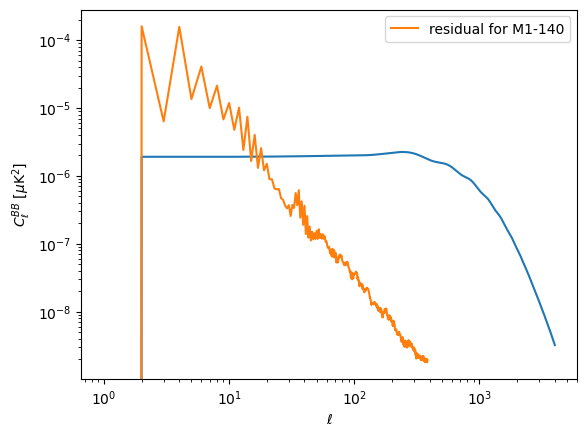

In [14]:
#run with ndim = 2
cl = sbm.load_fiducial_cl(r=0)

cl_140 = hp.anafast(apply_mask(freq_maps_res[14], mask))
plt.loglog((cl[2]))
plt.loglog((cl_140[2]), label= "residual for M1-140")
plt.legend()
plt.ylabel(r"$C^{BB}_{\ell}$ [$\mu$K$^2$]")
plt.xlabel(r"$\ell$")

Text(0.5, 0, '$\\ell$')

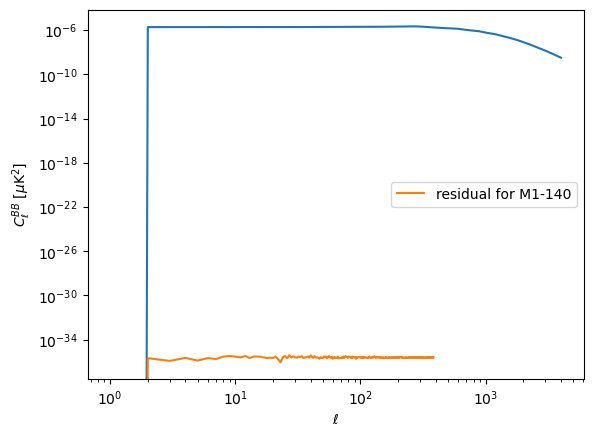

In [167]:
# run with ndim = 3
cl = sbm.load_fiducial_cl(r=0)

cl_140 = hp.anafast(apply_mask(freq_maps_res[14], mask))
plt.loglog((cl[2]))
plt.loglog((cl_140[2]), label= "residual for M1-140")
plt.legend()
plt.ylabel(r"$C^{BB}_{\ell}$ [$\mu$K$^2$]")
plt.xlabel(r"$\ell$")

In [13]:
from fgbuster import (
    CMB,
    Dust,
    Synchrotron,
    basic_comp_sep,
)

components = [CMB(), Dust(353.0), Synchrotron(23.0)]
cmb = sbm.generate_cmb(sf.nside, r=0, cmb_seed=12345)

cmb_fg = cmb + freq_maps
#hp.mollview(cmb_fg[0][1], title="CMB + FG", cmap=cmap, unit="$\mu K$")

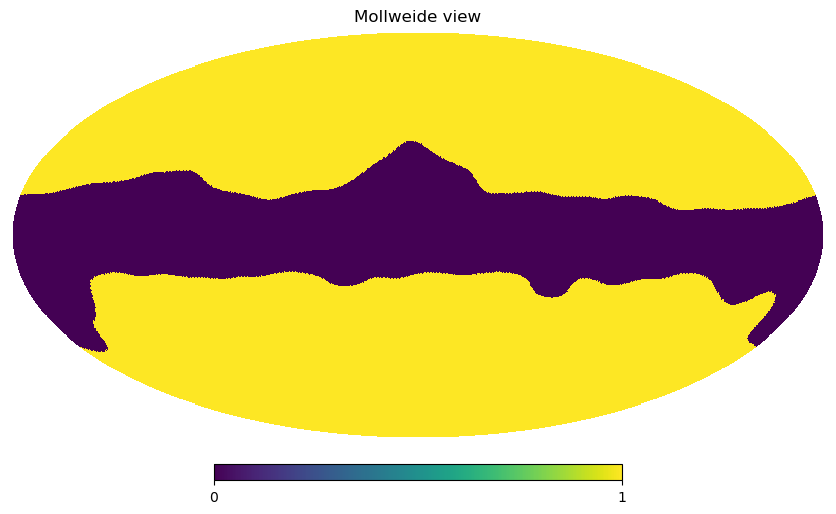

In [15]:
mask = hp.read_map(
    "../../HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=[3]
    #"/group/cmb/litebird/usr/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=[3]
)
mask = hp.ud_grade(mask, 256)
mask = hp.ud_grade(mask, 128)
hp.mollview(mask)

In [16]:
components = [CMB(), Dust(353.0), Synchrotron(23.0)]
instrument = sbm.get_instrument_table(imo)
m = cmb_fg[:, 1:, :] * mask
m[m == 0] = hp.UNSEEN
#result = basic_comp_sep(components, instrument, m)
result = basic_comp_sep(components, instrument, m)


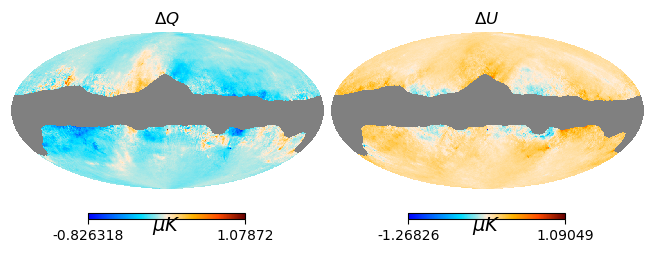

In [17]:
# run with mdim = 2
result_cmb = np.array([np.zeros(len(result.s[0][0])), result.s[0][0], result.s[0][1]])
compsep_res = (cmb - result_cmb) * mask
compsep_res[compsep_res == 0] = hp.UNSEEN

cl_res = hp.anafast(compsep_res)
hp.mollview(compsep_res[1], title="$\Delta Q$", cmap=cmap, unit="$\mu K$", sub=(1, 2, 1))
hp.mollview(compsep_res[2], title="$\Delta U$", cmap=cmap, unit="$\mu K$", sub=(1, 2, 2))

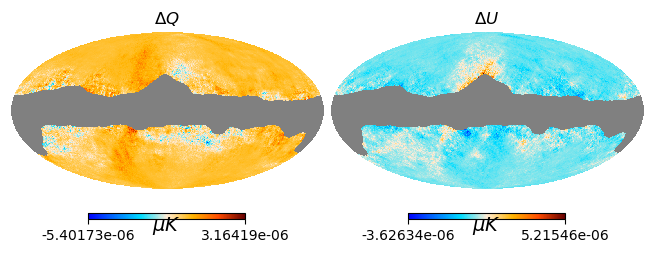

In [171]:
# run with mdim = 3
result_cmb = np.array([np.zeros(len(result.s[0][0])), result.s[0][0], result.s[0][1]])
compsep_res = (cmb - result_cmb) * mask
compsep_res[compsep_res == 0] = hp.UNSEEN

cl_res = hp.anafast(compsep_res)
hp.mollview(compsep_res[1], title="$\Delta Q$", cmap=cmap, unit="$\mu K$", sub=(1, 2, 1))
hp.mollview(compsep_res[2], title="$\Delta U$", cmap=cmap, unit="$\mu K$", sub=(1, 2, 2))

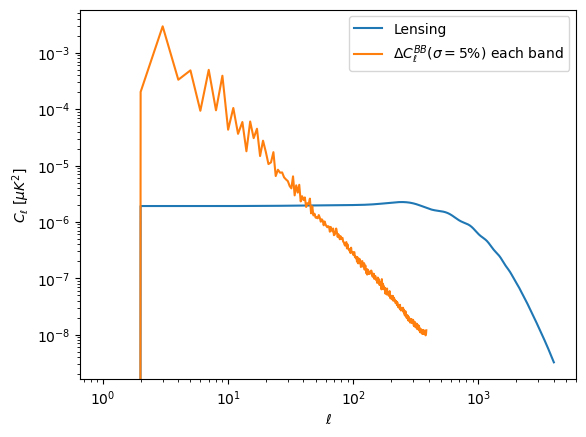

In [18]:
#run with mdim = 2
plt.loglog(cl[2], label="Lensing")
plt.loglog(cl_res[2], label=r"$\Delta C_\ell^{BB} (\sigma=5\%)$ each band")
plt.xlabel("$\ell$")
plt.ylabel("$C_{\ell}$ [$\mu K^2$]")
plt.legend()

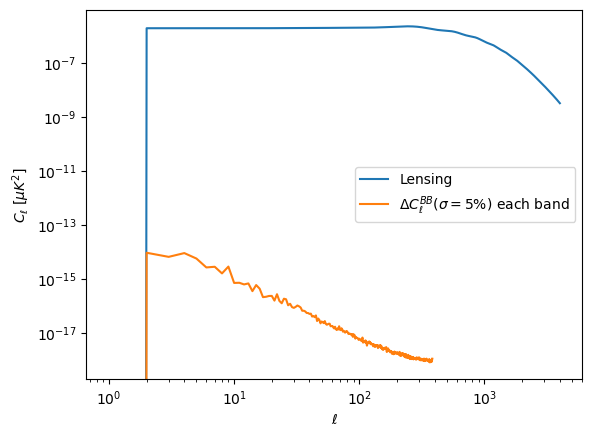

In [172]:
# run with mdim = 3
plt.loglog(cl[2], label="Lensing")
plt.loglog(cl_res[2], label=r"$\Delta C_\ell^{BB} (\sigma=5\%)$ each band")
plt.xlabel("$\ell$")
plt.ylabel("$C_{\ell}$ [$\mu K^2$]")
plt.legend()

Δr =  0.0328944543373888


Text(0, 0.5, 'Likelihood')

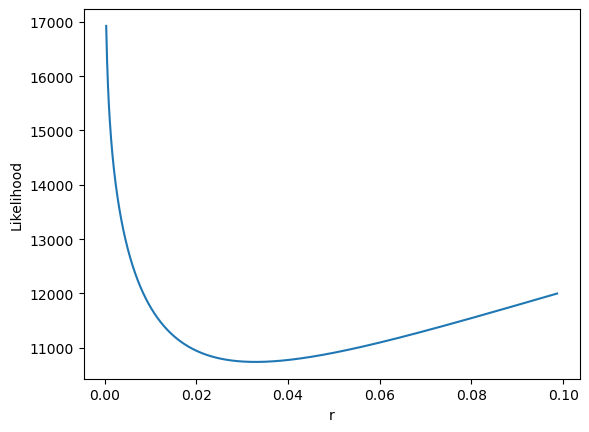

In [182]:
#run with mdim = 2
data = sbm.forecast(cl_res[2], fsky=0.6, lmax=191)
print("Δr = ", data["delta_r"])
plt.plot(data["grid_r"], data["likelihood"])
plt.xlabel("r")
plt.ylabel("Likelihood")

Δr =  1.0052484329816169e-10


Text(0, 0.5, 'Likelihood')

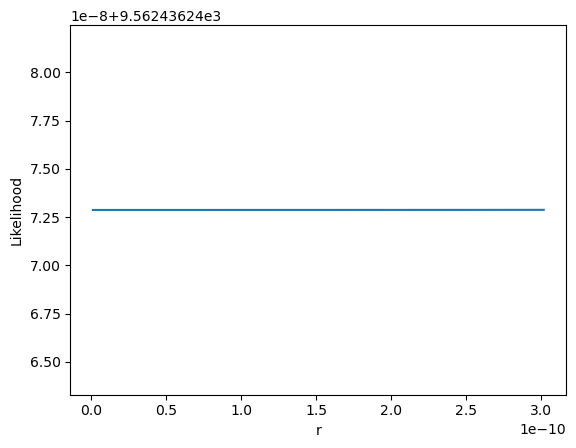

In [173]:
# run with mdim = 3
data = sbm.forecast(cl_res[2], fsky=0.6, lmax=191)
print("Δr = ", data["delta_r"])
plt.plot(data["grid_r"], data["likelihood"])
plt.xlabel("r")
plt.ylabel("Likelihood")